## Importe

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import jupyter_black

In [2]:
import anvil.tables as tables
from anvil.tables import app_tables

import anvil.server

anvil.server.connect("HID7XAECKWKWKEIE7XEKSQWT-DYTJOE4RGHHCEIV2")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [3]:
# Run Black for Better Formatting
jupyter_black.load()

In [4]:
# Display all columns
pd.set_option("display.max_columns", None)

In [5]:
# Importing File
fifa = pd.read_csv("players_fifa23.csv")

## Data Cleaning

In [6]:
# Setting Full Name as Index
fifa2 = fifa.drop_duplicates(subset=["FullName"]).set_index("FullName")

In [7]:
# Selection of numeric attributes that are useful for player recommendation
fifa3 = fifa2._get_numeric_data()
fifa4 = fifa3.drop(
    [
        "ID",
        "Growth",
        "TotalStats",
        "BaseStats",
        "ValueEUR",
        "WageEUR",
        "ReleaseClause",
        "ContractUntil",
        "ClubNumber",
        "ClubJoined",
        "OnLoad",
        "NationalNumber",
        "IntReputation",
        "GKDiving",
        "GKHandling",
        "GKKicking",
        "GKPositioning",
        "GKReflexes",
        "STRating",
        "LWRating",
        "LFRating",
        "CFRating",
        "RFRating",
        "RWRating",
        "CAMRating",
        "LMRating",
        "CMRating",
        "RMRating",
        "LWBRating",
        "CDMRating",
        "RWBRating",
        "LBRating",
        "CBRating",
        "RBRating",
        "GKRating",
    ],
    axis=1,
)

In [8]:
# Minmax Scaling
scaler = MinMaxScaler()

fifa5 = pd.DataFrame(
    scaler.fit_transform(fifa4), columns=fifa4.columns, index=fifa4.index
)

In [9]:
# Weighting: Overall-Skill & Potential should get a higher weight
fifa5["Overall"] = fifa5["Overall"] * 4
fifa5["Potential"] = fifa5["Potential"] * 2

## Recommendation System

In [10]:
# Instanciating of KNN and Fitting with Dataset
knn = NearestNeighbors(metric="cosine")
knn.fit(fifa5)

NearestNeighbors(metric='cosine')

In [11]:
# Calculation of Distance and Rank with KNN
distance, rank = knn.kneighbors(fifa5, 11)

In [12]:
# Buiding a Dict with Player Index and Player Name
id_name = fifa["FullName"].to_dict()

In [13]:
# Column with Player Name and Club
id_name_club = fifa[["FullName", "Club"]].drop_duplicates()
id_name_club["Name and Club"] = (
    id_name_club.FullName + " " + "(" + id_name_club.Club + ")"
)
id_name_club = id_name_club["Name and Club"].to_dict()

In [14]:
# Building a DataFrame with the Distances between Players
dist_df = pd.DataFrame(
    columns=[f"rank_{i}" for i in range(1, 11)],
    index=fifa5.index,
    data=distance[:, 1:],
)

In [15]:
# Building a DataFrame with Indices of similar Players and mapping it to Players id_name
similar_df = pd.DataFrame(
    columns=[f"rank_{i}_name" for i in range(1, 11)],
    index=fifa5.index,
    data=rank[:, 1:],
).apply(lambda x: x.map(id_name))

In [16]:
# Building a DataFrame with Indices of similar Players and mapping it to Players id_name with Club
similar_with_club_df = pd.DataFrame(
    columns=[f"rank_{i}_name_club" for i in range(1, 11)],
    index=fifa5.index,
    data=rank[:, 1:],
).apply(lambda x: x.map(id_name_club))

In [17]:
# Joining the different DataFrames together
df_data = fifa4.join(similar_df).join(dist_df).join(similar_with_club_df)

In [ ]:
# Droping rows with Nans
df_data = df_data.dropna(how="any")

In [50]:
def similar_player(player_name):
    player_name = df_data[df_data.index == player_name].index[0]

    ## Bar chart
    plt.figure(figsize=(12, 6))

    Xaxis = df_data.loc[player_name].values[-20:-10]
    Yaxis = df_data.loc[player_name].values[-10:]

    fig = sns.barplot(data=df_data, x=Xaxis, y=Yaxis, palette="mako")
    fig.set_title('Players similar to  " ' + str(player_name) + ' "')
    plt.show()

    ## Table display

    display_df = pd.concat(
        [
            df_data[df_data.index == player_name],
            df_data.loc[df_data.loc[player_name].values[42:52]],
        ]
    ).iloc[:, :42]

    display(display_df)

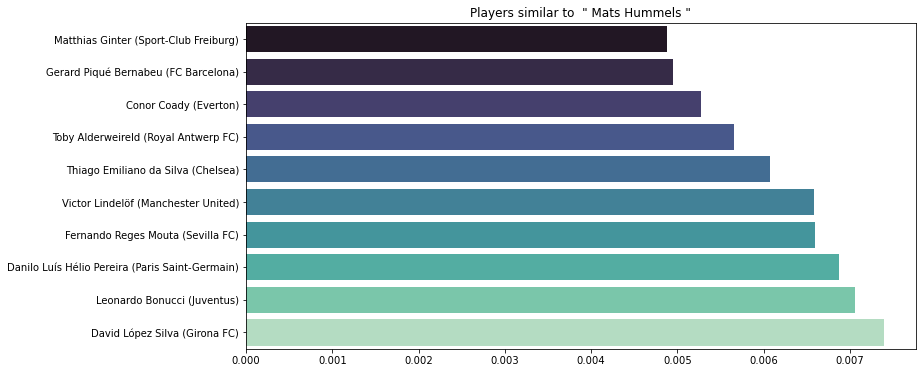

,Age,Height,Weight,Overall,Potential,WeakFoot,SkillMoves,PaceTotal,ShootingTotal,PassingTotal,DribblingTotal,DefendingTotal,PhysicalityTotal,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
FullName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Mats Hummels,33,191,94,84,84,3,3,53,59,76,72,87,78,65,57,86,81,64,69,66,53,85,78,45,60,60,86,62,71,70,66,87,49,71,87,57,80,68,89,88,86,85
Matthias Ginter,28,191,86,82,83,3,2,60,59,71,66,84,79,68,55,82,78,53,61,44,42,78,75,54,64,55,85,49,79,77,75,84,46,72,83,55,72,67,76,85,86,78
Gerard Piqué Bernabeu,35,194,85,83,83,3,2,56,61,71,68,83,76,57,65,83,80,57,63,58,43,82,80,48,62,56,80,34,62,73,61,83,51,79,83,66,72,69,86,82,84,82
Conor Coady,29,186,80,79,79,3,2,47,57,75,66,79,73,67,51,77,81,56,60,60,57,85,79,41,51,48,79,54,68,84,73,74,60,66,79,51,72,60,80,80,80,74
Toby Alderweireld,33,186,81,82,82,3,2,57,55,70,67,85,75,64,45,81,77,38,62,63,59,81,74,53,60,54,85,62,78,81,72,76,58,77,83,52,62,58,86,85,87,82
Thiago Emiliano da Silva,37,183,79,86,86,3,2,49,54,73,72,87,76,60,40,82,81,61,67,62,61,82,79,45,52,62,83,66,71,88,66,80,65,76,89,59,71,60,86,89,86,84
Victor Lindelöf,27,187,80,80,81,4,3,59,51,72,72,82,76,62,42,76,79,38,70,64,53,81,76,54,63,60,81,60,72,77,73,76,52,80,84,51,72,54,83,82,82,79
Fernando Reges Mouta,34,183,76,83,83,3,3,65,62,76,73,83,81,62,54,74,86,56,71,65,53,80,78,62,67,70,82,62,76,76,81,81,68,84,84,62,79,54,78,83,84,82
Danilo Luís Hélio Pereira,30,188,83,80,80,3,3,56,63,70,71,79,85,56,57,83,80,55,73,54,53,77,75,47,63,53,75,49,75,76,83,89,67,80,79,70,70,57,77,80,81,68


In [51]:
similar_player("Mats Hummels")

In [52]:
# Export of Dataset
# df_data.to_excel("Data.xlsx")

In [53]:
df_data.head()

,Age,Height,Weight,Overall,Potential,WeakFoot,SkillMoves,PaceTotal,ShootingTotal,PassingTotal,DribblingTotal,DefendingTotal,PhysicalityTotal,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,rank_1_name,rank_2_name,rank_3_name,rank_4_name,rank_5_name,rank_6_name,rank_7_name,rank_8_name,rank_9_name,rank_10_name,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10,rank_1_name_club,rank_2_name_club,rank_3_name_club,rank_4_name_club,rank_5_name_club,rank_6_name_club,rank_7_name_club,rank_8_name_club,rank_9_name_club,rank_10_name_club
FullName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Lionel Messi,35,169,67,91,91,4,4,81,89,90,94,34,64,84,90,70,91,88,95,93,93,90,93,87,76,91,92,95,86,68,70,68,91,44,40,93,94,75,96,20,35,24,Eden Hazard,Paulo Dybala,Riyad Mahrez,Neymar da Silva Santos Jr.,Iago Aspas Juncal,Dries Mertens,Mohamed Salah,Wissam Ben Yedder,Emil Forsberg,Alejandro Gómez,0.004689,0.004861,0.005289,0.005786,0.005806,0.006833,0.007142,0.007294,0.007709,0.007799,Eden Hazard (Real Madrid CF),Paulo Dybala (Roma),Riyad Mahrez (Manchester City),Neymar da Silva Santos Jr. (Paris Saint-Germain),Iago Aspas Juncal (RC Celta de Vigo),Dries Mertens (Galatasaray SK),Mohamed Salah (Liverpool),Wissam Ben Yedder (AS Monaco),Emil Forsberg (RB Leipzig),Alejandro Gómez (Sevilla FC)
Karim Benzema,34,185,81,91,91,4,4,80,88,83,87,39,78,75,92,90,89,88,87,82,73,76,91,79,80,78,92,72,87,79,82,82,80,63,39,92,89,84,90,43,24,18,Robert Lewandowski,C. Ronaldo dos Santos Aveiro,Patrik Schick,Gerard Moreno Balagueró,Pierre-Emerick Aubameyang,Iago Aspas Juncal,Heung Min Son,Ciro Immobile,Harry Kane,Sadio Mané,0.002461,0.003543,0.004275,0.004279,0.005031,0.005569,0.005610,0.005766,0.005880,0.005896,Robert Lewandowski (FC Barcelona),C. Ronaldo dos Santos Aveiro (Manchester United),Patrik Schick (Bayer 04 Leverkusen),Gerard Moreno Balagueró (Villarreal CF),Pierre-Emerick Aubameyang (Chelsea),Iago Aspas Juncal (RC Celta de Vigo),Heung Min Son (Tottenham Hotspur),Ciro Immobile (Lazio),Harry Kane (Tottenham Hotspur),Sadio Mané (FC Bayern München)
Robert Lewandowski,33,185,81,91,91,4,4,75,91,79,86,44,83,71,94,91,84,89,85,79,85,70,89,76,75,77,93,82,91,85,76,87,84,81,49,94,81,90,88,35,42,19,Karim Benzema,C. Ronaldo dos Santos Aveiro,Ciro Immobile,Gerard Moreno Balagueró,Luis Suárez,Harry Kane,Alexandre Lacazette,Patrik Schick,Arkadiusz Milik,Borja Iglesias Quintás,0.002461,0.004379,0.004684,0.004859,0.004948,0.005475,0.005522,0.006148,0.006568,0.006601,Karim Benzema (Real Madrid CF),C. Ronaldo dos Santos Aveiro (Manchester United),Ciro Immobile (Lazio),Gerard Moreno Balagueró (Villarreal CF),Luis Suárez (Club Nacional de Football),Harry Kane (Tottenham Hotspur),Alexandre Lacazette (Olympique Lyonnais),Patrik Schick (Bayer 04 Leverkusen),Arkadiusz Milik (Juventus),Borja Iglesias Quintás (Real Betis Balompié)
Kevin De Bruyne,31,181,70,91,91,5,4,74,88,93,87,64,77,94,85,55,93,83,88,89,83,93,90,76,73,76,91,78,92,63,88,74,91,75,66,88,94,83,89,68,65,53,Mason Mount,Marco Reus,İlkay Gündoğan,Youri Tielemans,Hakan Çalhanoğlu,Jonas Hofmann,Mario Götze,Bruno Miguel Borges Fernandes,Thomas Müller,Luka Modrić,0.003683,0.004314,0.004588,0.005224,0.005321,0.005411,0.005414,0.005455,0.005969,0.006024,Mason Mount (Chelsea),Marco Reus (Borussia Dortmund),İlkay Gündoğan (Manchester City),Youri Tielemans (Leicester City),Hakan Çalhanoğlu (Inter),Jonas Hofmann (Borussia Mönchengladbach),Mario Götze (Eintracht Frankfurt),Bruno Miguel Borges Fernandes (Manchester United),Thomas Müller (FC Bayern München),Luka Modrić (Real Madrid CF)
Kylian Mbappé,23,182,73,91,95,4,5,97,89,80,92,36,76,78,93,72,85,83,93,80,69,71,91,97,97,93,93,81,88,77,87,76,82,64,38,92,83,80,88,26,34,32,Luis Díaz,Vinícius José de O

<AxesSubplot:ylabel='FullName'>

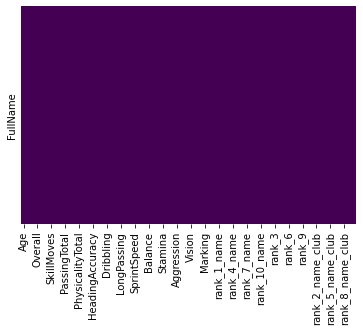

In [55]:
sns.heatmap(df_data.isnull(), yticklabels=False, cbar=False, cmap="viridis")

In [56]:
# Export of Dataset
df_data.to_csv("Data.csv", sep=";")

In [57]:
def import_csv_data(file):
    with open(file, "r", encoding="utf8") as f:
        df = pd.read_csv(f, sep=";")
        for d in df.to_dict(orient="records"):
            # d is now a dict of {columnname -> value} for this row
            # We use Python's **kwargs syntax to pass the whole dict as
            # keyword arguments
            app_tables.data.add_row(**d)

In [58]:
import_csv_data("Data.csv")

# Upload to Anvil
def import_excel_data(file):
    with open(file, "rb") as f:
        df = pd.read_excel(f)
        for d in df.to_dict(orient="records"):
            # d is now a dict of {columnname -> value} for this row
            # We use Python's **kwargs syntax to pass the whole dict as
            # keyword arguments
            app_tables.players.add_row(**d)


import_excel_data("Data.xlsx")

def import_csv_data(file):
    df = pd.read_csv(file, sep=";")
    for d in df.to_dict(orient="records"):
            # d is now a dict of {columnname -> value} for this row
            # We use Python's **kwargs syntax to pass the whole dict as
            # keyword arguments
            app_tables.data.add_row(**d)

In [59]:
fifa.shape

(18539, 90)